# Machine Learning Project 2

### Imports

In [18]:
import os
import shutil
import random
from pathlib import Path
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import itertools
import pandas as pd

## Data Understanding

### Analyse Class Distribution

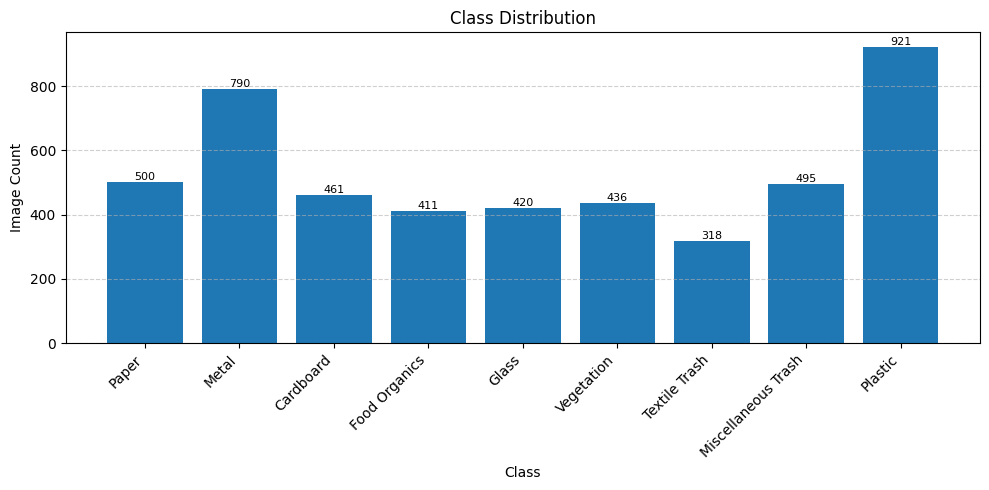

In [8]:
# Count images per class
class_counts = {}
for cls in os.listdir("RealWaste"):
    cls_path = os.path.join("RealWaste", cls)
    if os.path.isdir(cls_path):
        num_files = len([f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))])
        class_counts[cls] = num_files

# Show bar chart
plt.figure(figsize=(10, 5))
bars = plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45, ha='right')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.grid(axis='y', linestyle='--', alpha=0.6)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, str(height),
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

## Data Preparation

### Split into Train, Val and Test

In [9]:
def split_dataset(root_dir, output_dir, val_count=50, test_count=50):
    random.seed(42)

    classes = [d.name for d in Path(root_dir).iterdir() if d.is_dir()]

    for cls in classes:
        cls_path = Path(root_dir) / cls
        images = list(cls_path.glob('*'))
        total = len(images)
        random.shuffle(images)

        val_imgs = images[:val_count]
        test_imgs = images[val_count:val_count + test_count]
        train_imgs = images[val_count + test_count:]

        splits = {
            'train': train_imgs,
            'val': val_imgs,
            'test': test_imgs
        }

        for split, imgs in splits.items():
            split_dir = Path(output_dir) / split / cls
            split_dir.mkdir(parents=True, exist_ok=True)
            for img in imgs:
                shutil.copy(img, split_dir / img.name)

split_dataset("RealWaste", "RealWaste_splitted")

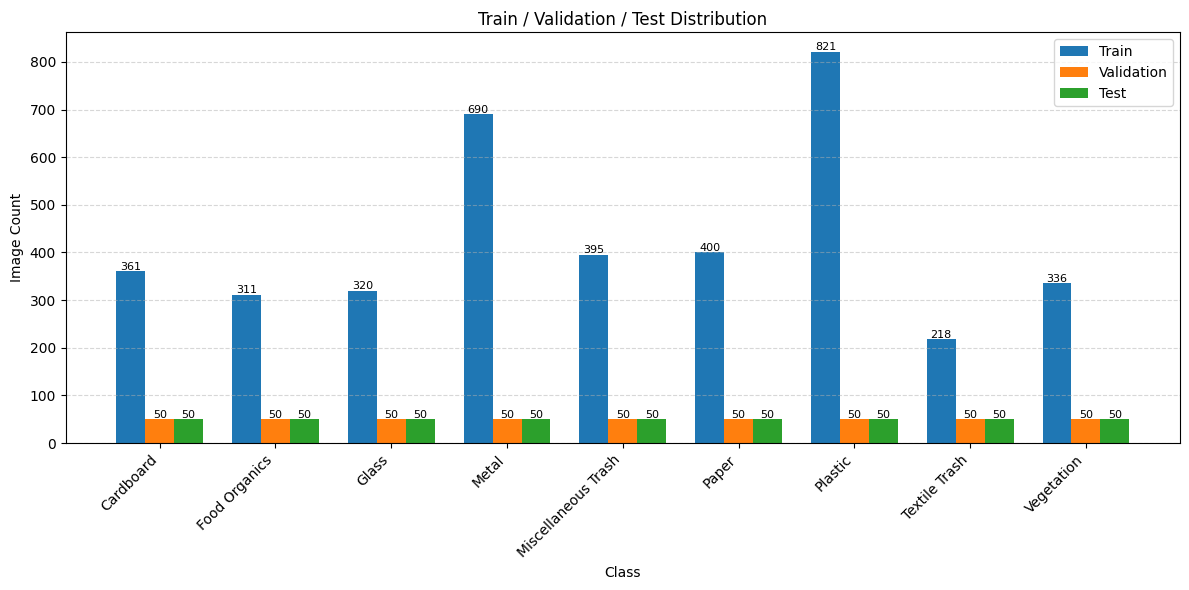

In [10]:
split_counts = {"train": {}, "val": {}, "test": {}}

for split in split_counts:
    split_path = os.path.join("RealWaste_splitted", split)
    if not os.path.exists(split_path):
        continue
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        if os.path.isdir(cls_path):
            split_counts[split][cls] = len([
                f for f in os.listdir(cls_path)
                if os.path.isfile(os.path.join(cls_path, f))
            ])

all_classes = sorted(set(k for split in split_counts.values() for k in split))

train_vals = [split_counts['train'].get(cls, 0) for cls in all_classes]
val_vals = [split_counts['val'].get(cls, 0) for cls in all_classes]
test_vals = [split_counts['test'].get(cls, 0) for cls in all_classes]

x = range(len(all_classes))
bar_width = 0.25

plt.figure(figsize=(12, 6))
plt.bar([i - bar_width for i in x], train_vals, width=bar_width, label='Train')
plt.bar(x, val_vals, width=bar_width, label='Validation')
plt.bar([i + bar_width for i in x], test_vals, width=bar_width, label='Test')

for i in x:
    plt.text(i - bar_width, train_vals[i] + 3, str(train_vals[i]), ha='center', fontsize=8)
    plt.text(i, val_vals[i] + 3, str(val_vals[i]), ha='center', fontsize=8)
    plt.text(i + bar_width, test_vals[i] + 3, str(test_vals[i]), ha='center', fontsize=8)

plt.xticks(x, all_classes, rotation=45, ha='right')
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.title("Train / Validation / Test Distribution")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Resizing, Augmentation, ToTensor

In [11]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(degrees=15),   
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),  
    transforms.ToTensor(), 
])

val_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

### Image Loader, Data Loader

In [12]:
train_data = ImageFolder(root="RealWaste_splitted/train", transform=train_transform)
val_data = ImageFolder(root="RealWaste_splitted/val", transform=val_test_transform)
test_data = ImageFolder(root="RealWaste_splitted/test", transform=val_test_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

## Modeling

### CNN Design

In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, conv_filters, fc_neurons, dropout_rate, use_batchnorm=True):
        super(CustomCNN, self).__init__()

        layers = []

        # 1. Convolutional Block
        layers.append(nn.Conv2d(3, conv_filters[0], kernel_size=3, padding=1))
        if use_batchnorm:
            layers.append(nn.BatchNorm2d(conv_filters[0]))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(2))

        # 2. Convolutional Block
        layers.append(nn.Conv2d(conv_filters[0], conv_filters[1], kernel_size=3, padding=1))
        if use_batchnorm:
            layers.append(nn.BatchNorm2d(conv_filters[1]))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(2))

        # 3. Convolutional Block
        layers.append(nn.Conv2d(conv_filters[1], conv_filters[2], kernel_size=3, padding=1))
        if use_batchnorm:
            layers.append(nn.BatchNorm2d(conv_filters[2]))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(2))

        # Features Block (CNN Teil)
        self.features = nn.Sequential(*layers)

        # Adaptive Average Pooling reduziert alles auf 1x1 unabhängig von Inputgröße
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Klassifikationsteil
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_filters[2], fc_neurons),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(fc_neurons, 9)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = self.classifier(x)
        return x


### Hyperparameter Tuning with Random Search

In [14]:
param_grid = {
    'learning_rate': [1e-2, 1e-3, 1e-4],
    'dropout_rate': [0.3, 0.5],
    'fc_neurons': [128, 256],
    'conv_filters': [[32, 64, 128], [16, 32, 64]]
}

In [15]:
def train_and_evaluate(params, train_dataset, val_dataset, device):

    model = CustomCNN(
        conv_filters=params['conv_filters'],
        fc_neurons=params['fc_neurons'],
        dropout_rate=params['dropout_rate']
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    criterion = torch.nn.CrossEntropyLoss()

    print(f"Testing combo: {params}")
    for epoch in range(3):
        print(f"  → Epoch {epoch+1}/3")
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = []

for combo in itertools.product(*param_grid.values()):
    keys = list(param_grid.keys())
    params = dict(zip(keys, combo))
    val_acc = train_and_evaluate(params, train_data, val_data, device)
    results.append({**params, 'val_accuracy': round(val_acc, 4)})

Testing combo: {'learning_rate': 0.01, 'dropout_rate': 0.3, 'fc_neurons': 128, 'conv_filters': [32, 64, 128]}
  → Epoch 1/3
  → Epoch 2/3
  → Epoch 3/3
Testing combo: {'learning_rate': 0.01, 'dropout_rate': 0.3, 'fc_neurons': 128, 'conv_filters': [16, 32, 64]}
  → Epoch 1/3
  → Epoch 2/3
  → Epoch 3/3
Testing combo: {'learning_rate': 0.01, 'dropout_rate': 0.3, 'fc_neurons': 256, 'conv_filters': [32, 64, 128]}
  → Epoch 1/3
  → Epoch 2/3
  → Epoch 3/3
Testing combo: {'learning_rate': 0.01, 'dropout_rate': 0.3, 'fc_neurons': 256, 'conv_filters': [16, 32, 64]}
  → Epoch 1/3
  → Epoch 2/3
  → Epoch 3/3
Testing combo: {'learning_rate': 0.01, 'dropout_rate': 0.5, 'fc_neurons': 128, 'conv_filters': [32, 64, 128]}
  → Epoch 1/3
  → Epoch 2/3
  → Epoch 3/3
Testing combo: {'learning_rate': 0.01, 'dropout_rate': 0.5, 'fc_neurons': 128, 'conv_filters': [16, 32, 64]}
  → Epoch 1/3
  → Epoch 2/3
  → Epoch 3/3
Testing combo: {'learning_rate': 0.01, 'dropout_rate': 0.5, 'fc_neurons': 256, 'conv_filter

In [17]:
df = pd.DataFrame(results)
df = df.sort_values(by='val_accuracy', ascending=False)
print(df)

    learning_rate  dropout_rate  fc_neurons   conv_filters  val_accuracy
11         0.0010           0.3         256   [16, 32, 64]        0.4867
10         0.0010           0.3         256  [32, 64, 128]        0.4689
12         0.0010           0.5         128  [32, 64, 128]        0.4311
15         0.0010           0.5         256   [16, 32, 64]        0.4111
13         0.0010           0.5         128   [16, 32, 64]        0.3822
18         0.0001           0.3         256  [32, 64, 128]        0.3756
8          0.0010           0.3         128  [32, 64, 128]        0.3556
14         0.0010           0.5         256  [32, 64, 128]        0.3400
16         0.0001           0.3         128  [32, 64, 128]        0.3378
9          0.0010           0.3         128   [16, 32, 64]        0.3311
22         0.0001           0.5         256  [32, 64, 128]        0.3289
19         0.0001           0.3         256   [16, 32, 64]        0.3133
20         0.0001           0.5         128  [32, 6

## Evaluation